In [1]:
                                                   # CNN Audio Classification
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import tensorflow as tf

audio_dataset_path="C:/Users/mukhe/Downloads/UrbanSound8K/UrbanSound8K/audio"
metadata_dataset_path="C:/Users/mukhe/Downloads/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
metadata=pd.read_csv(metadata_dataset_path)

In [2]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
### Check whether the dataset is imbalanced
classes = metadata['class'].unique()
counts = metadata['class'].value_counts()


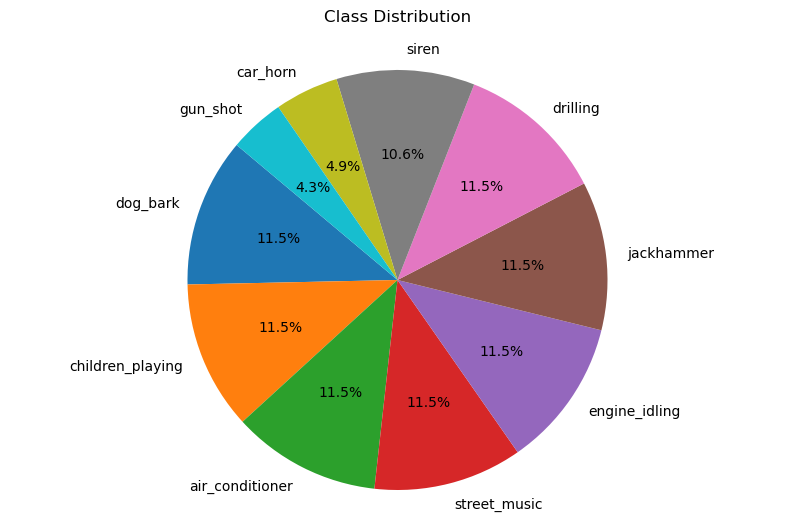

In [4]:
# Create the pie chart
plt.figure(figsize=(10, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Class Distribution', pad=20) #pad is for creating gap b/w title and plot

# Display the pie chart
plt.show()

In [5]:
max_pad_len = 174

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [6]:
features = []

# Iterate through each sound file and extract the features 
for index, row in tqdm(metadata.iterrows()):
    
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

3553it [02:51, 19.60it/s]C:\Users\mukhe\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8324it [07:00, 28.86it/s]C:\Users\mukhe\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
C:\Users\mukhe\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [07:19, 19.86it/s]

Finished feature extraction from  8732  files


In [7]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [8]:
yy.shape

(8732, 10)

In [9]:
y_train.shape

(6985, 10)

In [10]:
yy.shape[1]

10

In [11]:
from keras.models import Sequential
from keras.layers import Input,Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn import metrics 

num_rows = 40
num_columns = 174
num_channels = 1

X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Input(shape=(num_rows, num_columns, num_channels)))
model.add(Conv2D(filters=16, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 39, 173, 16)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 86, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 86, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 18, 85, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 42, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 42, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 41, 64)      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 20, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 20, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 19, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,602 (174.23 KB)

 Trainable params: 44,602 (174.23 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [14]:
# to stop when improvement of model stops
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [15]:
# Check the shape of the training and test data
print(X_train.shape)  # Should be (num_samples, num_rows, num_columns, num_channels)
print(y_train.shape)  # Should be (num_samples, num_labels)
print(X_test.shape)   # Should be (num_samples, num_rows, num_columns, num_channels)
print(y_test.shape)   # Should be (num_samples, num_labels)


(6985, 40, 174, 1)
(6985, 10)
(1747, 40, 174, 1)
(1747, 10)


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 1000
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='C:/Users/mukhe/Downloads/Audio classification saved model.keras', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer,early_stopping], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/1000
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2895 - loss: 3.0253
Epoch 1: val_loss improved from inf to 1.48328, saving model to C:/Users/mukhe/Downloads/Audio classification saved model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.2905 - loss: 3.0157 - val_accuracy: 0.4946 - val_loss: 1.4833
Epoch 2/1000
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5541 - loss: 1.3103
Epoch 2: val_loss improved from 1.48328 to 1.22920, saving model to C:/Users/mukhe/Downloads/Audio classification saved model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5542 - loss: 1.3097 - val_accuracy: 0.6005 - val_loss: 1.2292
Epoch 3/1000
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6246 - loss: 1.0894
Epoch 3: val_loss improved from 1.22920 to 1.19373, saving model to C:/Users/mukhe/Downloads/Audio classification saved model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6248 - loss: 1.0888 - val_accuracy: 0.5753 - val_

In [17]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9221522808074951


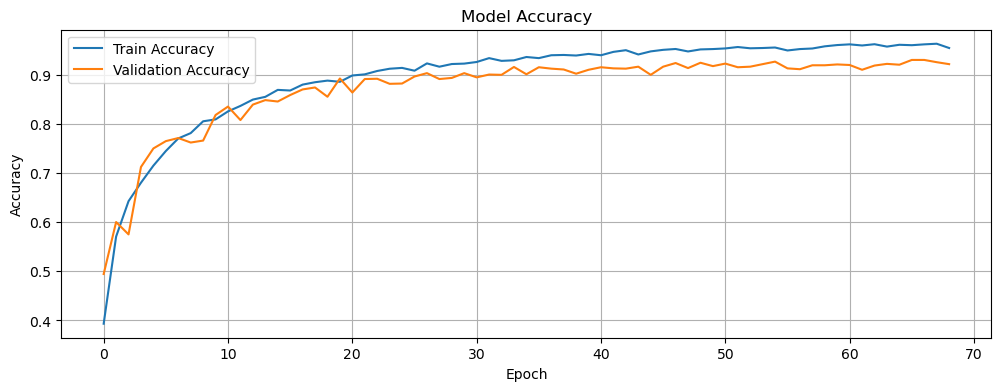

In [18]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

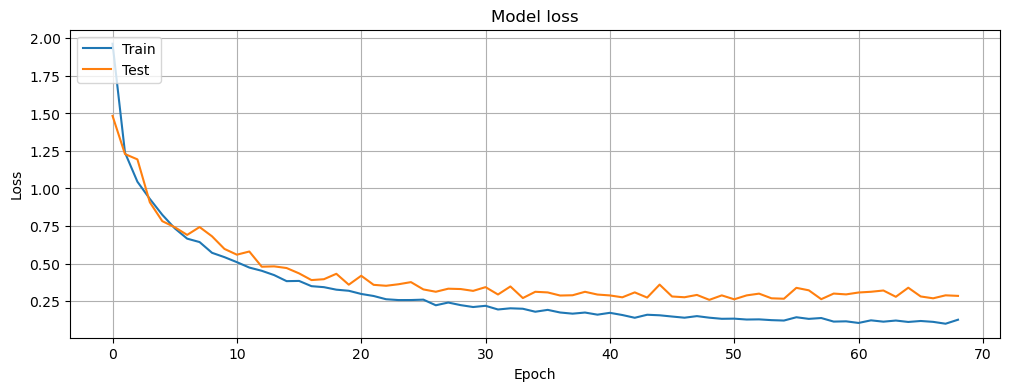

In [19]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)
plt.show()

In [20]:
#...........................................................Model testing...............................................................

In [21]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name)
    
    if prediction_feature is None:
        print(f"Failed to extract features from file: {file_name}")
        return
    
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    # Predict class
    predicted_vector = np.argmax(model.predict(prediction_feature), axis=1)
    predicted_class = le.inverse_transform(predicted_vector)
    print("The Predicted Class is:", predicted_class[0], '\n')

    # Predict probabilities
    predicted_proba_vector = model.predict(prediction_feature)

    for i in range(len(predicted_proba_vector[0])):
        category = le.inverse_transform([i])
        print(f"{category[0]} \t\t : {predicted_proba_vector[0][i]:.32f}")


In [49]:
def normalize_path(path):
    # Convert to an absolute path
    absolute_path = os.path.abspath(path)
    # Convert backslashes to forward slashes
    normalized_path = absolute_path.replace("\\", "/")
    return normalized_path

In [53]:
file_path=r"C:\Users\mukhe\Downloads\mixkit-dog-barking-twice-1.wav"
print(normalize_path(file_path))
ipd.Audio(normalize_path(file_path))

C:/Users/mukhe/Downloads/mixkit-dog-barking-twice-1.wav


In [24]:
print_prediction(file_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
The Predicted Class is: dog_bark 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
air_conditioner 		 : 0.00000000003300288514695992603265
car_horn 		 : 0.00000000000182429592265886952873
children_playing 		 : 0.00020019165822304785251617431641
dog_bark 		 : 0.99979978799819946289062500000000
drilling 		 : 0.00000000012271887672721248918606
engine_idling 		 : 0.00000000000166321188592444269005
gun_shot 		 : 0.00000000000176231989071351513587
jackhammer 		 : 0.00000000000000000000000390936154
siren 		 : 0.00000000000001269727798922613837
street_music 		 : 0.00000000187356885561484887148254


In [ ]:
# testing was success ...... model successfully deployed